<a href="https://colab.research.google.com/github/dagyaom/Python_Practice/blob/main/%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8_%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80%EC%A7%80%ED%91%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install category_encoders

     |████████████████████████████████| 80 kB 3.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
# 이번에는 타겟으로 계절독감백신 접종여부를 사용하겠습니다.

target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
# 테스트 데이터 수를 n=14052 로 한정합니다.
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv').iloc[:14052]
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

from sklearn.model_selection import train_test_split

# 검증세트를 테스트세트와 크기와 같도록 만듭니다.
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
        
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    # 계절독감(seas)에 대한 모델을 학습할 것이기 때문에 h1n1에 대한 특성을 제거합니다.
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)

        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


검증 정확도:  0.7548391688015941


# Confusion matrix

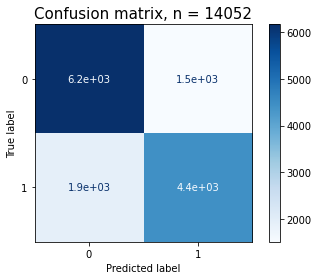

In [4]:
# 1) 혼동행렬 그림으로 나타내기
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                           );
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()


#cmap=plt.cm.Blues, :파란색 컬러맵으로 지정
# 1 : 백신 맞았다.
# 0 : 백신 안맞았다.

In [5]:
# 2) 혼동행렬 어레이로 나타내기 1)
cm = pcm.confusion_matrix
cm

array([[6165, 1515],
       [1930, 4442]])

In [6]:
# 2) 혼동행렬 어레이로 나타내기 2) 
from sklearn.metrics import confusion_matrix
ccm = confusion_matrix(y_val, y_pred)
ccm

array([[6165, 1515],
       [1930, 4442]])

# 1) accuracy
하나의 데이터셋에 대해 3가지의 모델을 썼다고 가정할 때, 
1번모델에서 정확도 0.5, 2번 모델에서 정확도 0.8, 3번 모델에서 정확도 0.9가 나온다면 3번 모델이 가장 합리적이라고 할 수 있겠지만,
만약 데이터가 imbalaced할 때에는, 1번 모델이 더 정확할 수도 있음.
예를 들어 백신주사를 맞았다 / 안맞았다에 대해 예측할 때에,
맞은 사람의 실제값이 100명이고 안맞은 사람이 실제값이 100명일 때는 accuracy 지표가 정확할 수 있다. 그런데 맞은사람은 100명인데, 안맞은 사람은 10명일 경우 이 데이터로 모델을 만든다고 할 때, 정확도로 평가하게 되면, 
맞은 사람에 대해 모델이 잘 맞췄더라도 안맞은 사람 10명에 대해 1명만 맞추고 9명은 오답내는 모델일지라도 정확도는 높게나온다. 전체 예측한 것 중에 맞게 예측한 것만 따지기 때문.

그래서 무슨 평가지표를 쓸 것인지 결정하는 부분에서, 훈련데이터의 결과값에 비율을 잘 따져봐야 한다. 

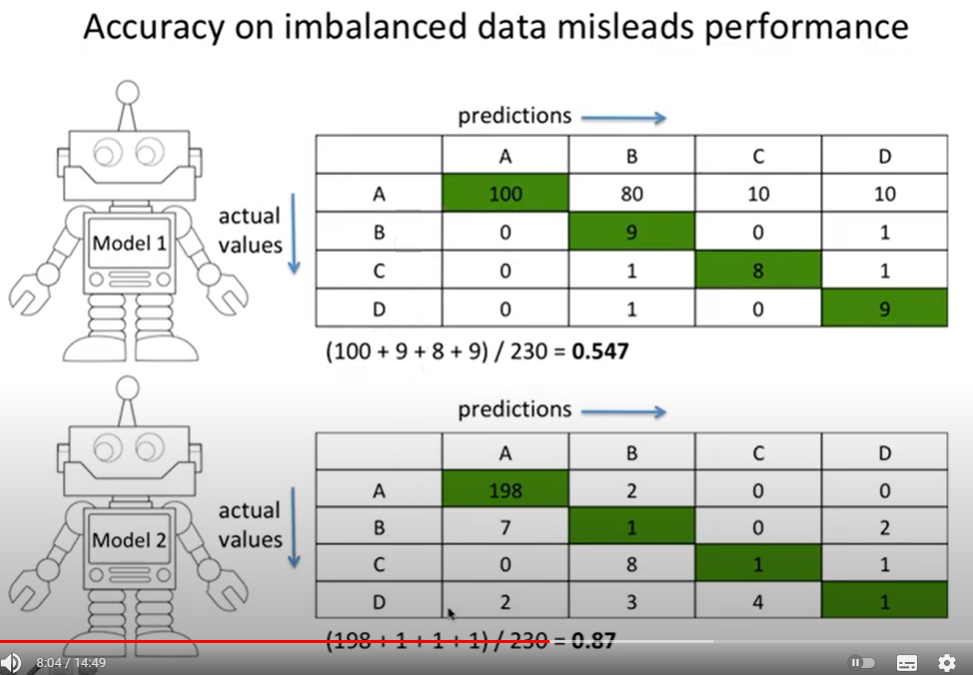

In [30]:
# 정확하게 맞춘 예측
correct_predictions = np.diag(cm, k=0).sum()  # k값 바꿔보기
print(correct_predictions)

# np.diag : https://numpy.org/doc/stable/reference/generated/numpy.diag.html\
# numpy.diag(v, k=0) : 대각선을 추출하거나 대각선 배열을 구성합니다. v가 2차원 배열이면 k번째 대각선의 복사본을 반환합니다.(k 디폴트 = 0) v가 1차원 배열이면 k번째 대각선에 v가 있는 2차원 배열을 반환합니다.

# 총 예측한 수
total_predictions = cm.sum()
print(total_predictions)

# 분류 정확도(classification accuracy)
print(correct_predictions/total_predictions)

# 메서드를 활용한 정확도
print('검증 정확도: ', accuracy_score(y_val, y_pred))

10607
14052
0.7548391688015941
검증 정확도:  0.7548391688015941


# 2) 정예실, 재실예

- 정밀도(Precision) : positive로 예측한 것 중 실제 positive : 
$\large \frac{TP}{TP + FP}$
- 재현율(recall) : 실제 positive중에서 예측 positive : $\large \frac{TP}{TP + FN}$

- F1점수  (F-beta score 중에서 beta가 1인 경우를 나타냄):   $ 2\cdot\large\frac{precision\cdot recall}{precision + recall}$

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

# 주사맞은 사람 : 1
# 정밀도 : 주사맞았다고 예측한 사람 중에 실제 주사맞은 사람의 비율 0.75
# 정밀도 : 주사 안맞았다고 예측한 사람 중에 진짜 주사안맞은 사람의 비율 : 0.76
# 재현율 : 실제 주사맞은 사람 중에 모델이 제대로 예측한 주사맞은 사람의 비율 : 0.70
# 재현율 : 실제 주사를 안맞은 사람중에 모델이 주사 안맞았다고 예측한 사람 비율 : 0.80

              precision    recall  f1-score   support

           0       0.76      0.80      0.78      7680
           1       0.75      0.70      0.72      6372

    accuracy                           0.75     14052
   macro avg       0.75      0.75      0.75     14052
weighted avg       0.75      0.75      0.75     14052



In [9]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fp + fn

In [10]:
real_positives = tp + fn
real_positives

6372

In [11]:
# 양지면에서 집단면역을 위한 백신 접종 수
herdImmunity = total * 0.7
herdImmunity

9836.4

In [12]:
# 집단면역을 위해 추가 접종이 필요한 인원
herdImmunity - real_positives  #real_positives=실제 백신 접종한 사람

3464.3999999999996

In [13]:
print(y_train.value_counts(normalize=True))  # 0 = 안맞은사람, 1=알아서 맞는 사람
true_ratio = y_train.value_counts(normalize=True)[1]
true_ratio

0    0.546545
1    0.453455
Name: vacc_seas_f, dtype: float64


0.4534552700875383

In [14]:
public_vacc = 4500
overlap = public_vacc * true_ratio  # 무료백신갯수 * 알아서 백신맞는사람의 비율 = 무료 백신을 하게 될때 발생하는 알아서 백신 맞는 사람 수요! (무료백신 없다고 하면 본인돈 내고 맞았겠지만 무료라고 하니 와서 맞을 사람들)
overlap

2040.5487153939223

In [15]:
lack = herdImmunity - (public_vacc + real_positives - overlap)  #집단면역에 필요한 인원수 - (무료백신갯수 + 백신맞은사람수 - 공짜로맞고싶은 알아서 백신맞는사람들 )
lack 

#무료백신으로 맞출수있는사람4500명 + 백신맞을사람 6732명, 총 11232명이 맞으면 집단면역에 필요한 9836.4명보다 많지만, 
# 11232에서 공짜로 맞는 알아서 백신맞을 사람들을 빼버리면(중첩되니까)
#11232-2040 = 9192명. 즉 백신맞은사람수는 9192명인데, 집단면역에는 9836명이 필요하므로, 갭 발생.(내 계산에는 오차가 있음.)

1004.9487153939226

In [16]:
pipe.classes_

array([0, 1])

In [17]:
pipe.predict(X_val)

array([1, 0, 0, ..., 1, 1, 0])

In [18]:
pipe.predict_proba(X_val) 
# 확률값 반환. 첫번째 사람이 알아서 맞는다고 예측했을 때, 54%의 확률로 예측하였다는 것.

array([[0.46      , 0.54      ],
       [0.85      , 0.15      ],
       [0.78      , 0.22      ],
       ...,
       [0.14      , 0.86      ],
       [0.38459524, 0.61540476],
       [0.92      , 0.08      ]])

In [19]:
# 백신접종 확률 #모든 사람에 대해, 백신접종할 확률.
y_pred_proba = pipe.predict_proba(X_val)[:, 1] 
y_pred_proba

array([0.54      , 0.15      , 0.22      , ..., 0.86      , 0.61540476,
       0.08      ])

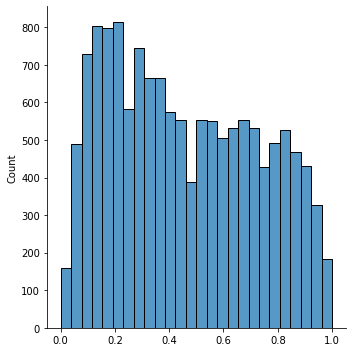

In [20]:
import seaborn as sns
sns.displot(y_pred_proba);  # 백신맞을 확률에 대한 수. 백신맞을 확률이 0%인 사람이 150명. 백신맞을 확률이 0.5인사람 확률이 390명 등..

False    8095
True     5957
dtype: int64

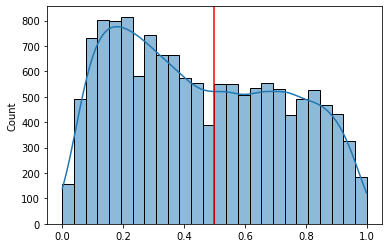

In [21]:
# Randomforestclassifier 기본 임계값은 0.5입니다. : 백신맞을 확률이 0.5% 이상이면 백신 알아서 맞을 사람(1)으로 분류하겠다.
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold  # true 와 false로 나뉘어짐.

ax = sns.histplot(y_pred_proba, kde=True)  #kde=True 그래프에 전체적인 곡선? 을 그려주는 옵션.
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()  #임계값 0.5보다 큰 사람은 8095명(알아서 백신 맞을 사람), 임계값 0.5보다 작은 사람수는 5957명(백신 안맞는 사람)

In [26]:
from ipywidgets import interact, fixed

def explore_threshold(threshold=0.5):
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_val, y_pred))

    
interact(explore_threshold,  
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [50]:
from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

    
# fixed : 고정한다는게 뭘 고정한다는 것이야.. ★

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [33]:
pred_proba = pd.DataFrame({
    'y_val': y_val,
    'pred_proba': y_pred_proba})
pred_proba

,y_val,pred_proba
10296,0,0.540000
3515,0,0.150000
13103,0,0.220000
31432,1,1.000000
38296,1,0.060000
...,...,...
6815,0,0.180000
34682,1,0.900000
21444,1,0.860000
19491,1,0.615405


In [34]:
#백신접종확률 낮은순서로 정렬
top = pred_proba.sort_values(by='pred_proba', ascending=True)[:4500]
top

,y_val,pred_proba
10271,0,0.00
25027,0,0.00
37061,0,0.00
12209,0,0.00
4718,0,0.00
...,...,...
32901,0,0.27
39458,0,0.27
28620,0,0.27
34079,0,0.27


In [35]:
# 접종 확률이 낮음에도 접종한 사람들 650명(FN)
vc = top['y_val'].value_counts()
vc

0    3850
1     650
Name: y_val, dtype: int64

In [36]:
final = real_positives + vc[0]
final

10222

In [37]:
final > herdImmunity

True

In [47]:
vc_rand = pred_proba[pred_proba['pred_proba'] < 0.5].sample(4500, random_state=2)['y_val'].value_counts()

In [39]:
pred_proba

,y_val,pred_proba
10296,0,0.540000
3515,0,0.150000
13103,0,0.220000
31432,1,1.000000
38296,1,0.060000
...,...,...
6815,0,0.180000
34682,1,0.900000
21444,1,0.860000
19491,1,0.615405


In [40]:
pred_proba[pred_proba['pred_proba'] < 0.5]

,y_val,pred_proba
3515,0,0.15
13103,0,0.22
38296,1,0.06
7127,1,0.46
36252,0,0.25
...,...,...
36201,0,0.21
3772,0,0.34
5048,0,0.14
6815,0,0.18


In [43]:
pred_proba[pred_proba['pred_proba'] < 0.5].sample(4500, random_state=2)

,y_val,pred_proba
30070,0,0.48
4448,0,0.20
30614,0,0.27
26267,0,0.38
38877,1,0.49
...,...,...
19297,0,0.44
9653,0,0.15
21970,0,0.16
34082,1,0.38


In [44]:
pred_proba[pred_proba['pred_proba'] < 0.5].sample(4500, random_state=2)['y_val']

30070    0
4448     0
30614    0
26267    0
38877    1
        ..
19297    0
9653     0
21970    0
34082    1
27980    0
Name: y_val, Length: 4500, dtype: int64

In [45]:
pred_proba[pred_proba['pred_proba'] < 0.5].sample(4500, random_state=2)['y_val'].value_counts()

0    3455
1    1045
Name: y_val, dtype: int64

In [48]:
final_rand = real_positives + vc_rand[0]
final_rand

9827

In [49]:
final_rand > herdImmunity

False

# ROC curve : 임계값 한눈에 보고 모델 평가하기.
이렇듯 분류문제에서 임계값을 잘 설정한다면 보다 효율적으로 문제를 해결할 수 있을텐데,

모든 임계값을 한 눈에 보고 모델을 평가할 수 있는 방법이 있을까요?